In [1]:
import proplot as pplt

import numpy as np
import galsim
import ngmix

In [122]:
from ngmix.prepsfmom import _build_square_apodization_mask

def _run(flux_factor, ap_rad):
    image_size = 53
    pixel_scale = 0.25
    fwhm = 0.9
    mom_fwhm = 2.0
    pad_factor = 4

    cen = (image_size - 1)/2
    gs_wcs = galsim.ShearWCS(
        pixel_scale, galsim.Shear(g1=-0, g2=0.0)).jacobian()
    scale = np.sqrt(gs_wcs.pixelArea())
    shift = rng.uniform(low=-scale/2, high=scale/2, size=2)
    xy = gs_wcs.toImage(galsim.PositionD(shift))

    jac = Jacobian(
        y=cen + xy.y, x=cen + xy.x,
        dudx=gs_wcs.dudx, dudy=gs_wcs.dudy,
        dvdx=gs_wcs.dvdx, dvdy=gs_wcs.dvdy)

    gal = galsim.Gaussian(
        fwhm=fwhm
    ).shear(
        g1=-0.1, g2=0.2
    ).withFlux(
        400
    ).shift(
        dx=shift[0], dy=shift[1]
    )

    # get true flux
    im_true = gal.drawImage(
        nx=image_size,
        ny=image_size,
        wcs=gs_wcs,
    ).array
    
    im = im_true.copy()
    im += galsim.Exponential(
        half_light_radius=fwhm
    ).shear(
        g1=-0.5, g2=0.2
    ).shift(
        cen*pixel_scale,
        0,
    ).withFlux(
        400*flux_factor
    ).drawImage(
        nx=image_size,
        ny=image_size,
        wcs=gs_wcs,
        method="real_space",
    ).array


    obs_true = Observation(
        image=im_true,
        jacobian=jac,
    )
    res_true = PGaussMom(fwhm=mom_fwhm, pad_factor=pad_factor, ap_rad=ap_rad).go(
        obs=obs_true, no_psf=True, return_kernels=True,
    )

    obs = Observation(
        image=im,
        jacobian=jac,
    )
    res = PGaussMom(fwhm=mom_fwhm, pad_factor=pad_factor, ap_rad=ap_rad).go(
        obs=obs, no_psf=True, return_kernels=True,
    )

    ap_mask = np.ones_like(im)
    if ap_rad > 0:
        _build_square_apodization_mask(ap_rad, ap_mask)
    obs_ap = Observation(
        image=im * ap_mask,
        jacobian=jac,
    )

    from ngmix.gaussmom import GaussMom
    res_gmom = GaussMom(fwhm=mom_fwhm).go(obs=obs_ap)

    for k in sorted(res):
        if k in res_gmom and k in ["flux", "T", "e1", "e2"]:
            print("%s:" % k, res[k], res_true[k], res_gmom[k])

            
    return im, ap_mask

In [123]:
_run(1e4, 0)
im, apm = _run(1e4, 1.5)

T: 0.2779688328784303 0.2637209978638228 0.269235559300075
e1: -0.08274139057958897 -0.154806691325152 -0.1351019093318664
e2: 0.2857215665735373 0.30961996276982773 0.29751540879264865
flux: 324.73368504865357 325.90375349006695 326.15867844530436
apodizing
apodizing
T: 0.26853075366336904 0.26372100379560626 0.26881276958081723
e1: -0.13702035469789214 -0.15480664988869494 -0.13659920553461993
e2: 0.2985847799493347 0.3096199311833405 0.2983936588876356
flux: 326.0760649851062 325.9037498926239 326.1395798235066


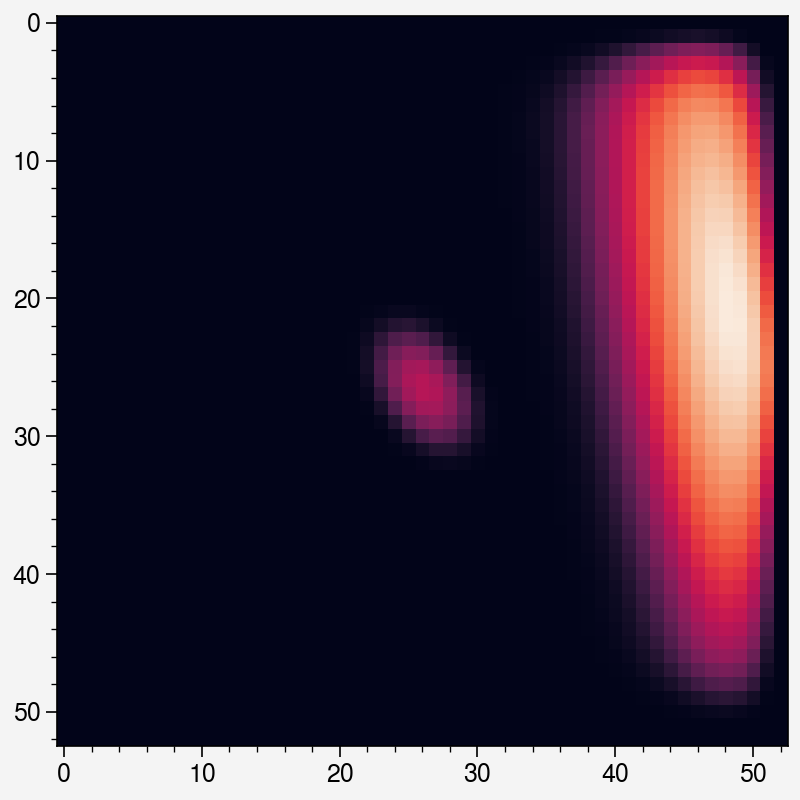

In [124]:
fig, axs = pplt.subplots(figsize=(4, 4))

axs[0].imshow(np.arcsinh(im*apm), cmap="rocket")
axs[0].grid(False)

In [48]:
from ngmix import Jacobian, Observation
from ngmix.prepsfmom import PGaussMom

def _run(flux_factor, ap_rad):
    rng = np.random.RandomState(seed=100)
    image_size = 401
    psf_image_size = 53
    pixel_scale = 0.25
    fwhm = 0.9
    psf_fwhm = 0.8
    mom_fwhm = 2.0
    pad_factor = 4

    snr = 1e8
    mom_fwhm = 2.0

    cen = (image_size - 1)/2
    psf_cen = (psf_image_size - 1)/2
    gs_wcs = galsim.ShearWCS(
        pixel_scale, galsim.Shear(g1=-0.0, g2=0.0)).jacobian()
    scale = np.sqrt(gs_wcs.pixelArea())
    shift = rng.uniform(low=-scale/2, high=scale/2, size=2)
    psf_shift = rng.uniform(low=-scale/2, high=scale/2, size=2)
    xy = gs_wcs.toImage(galsim.PositionD(shift))
    psf_xy = gs_wcs.toImage(galsim.PositionD(psf_shift))

    jac = Jacobian(
        y=cen + xy.y, x=cen + xy.x,
        dudx=gs_wcs.dudx, dudy=gs_wcs.dudy,
        dvdx=gs_wcs.dvdx, dvdy=gs_wcs.dvdy)

    psf_jac = Jacobian(
        y=psf_cen + psf_xy.y, x=psf_cen + psf_xy.x,
        dudx=gs_wcs.dudx, dudy=gs_wcs.dudy,
        dvdx=gs_wcs.dvdx, dvdy=gs_wcs.dvdy)

    gal = galsim.Gaussian(
        fwhm=fwhm
    ).shear(
        g1=-0.1, g2=0.2
    ).withFlux(
        400
    ).shift(
        dx=shift[0], dy=shift[1]
    )
    psf = galsim.Gaussian(
        fwhm=psf_fwhm
    ).shear(
        g1=0.3, g2=-0.15
    )
    im = galsim.Convolve([gal, psf]).drawImage(
        nx=image_size,
        ny=image_size,
        wcs=gs_wcs
    ).array
    noise = np.sqrt(np.sum(im**2)) / snr
    wgt = np.ones_like(im) / noise**2

    im_orig = im.copy()


    im += galsim.Gaussian(
        fwhm=fwhm*10
    ).shear(
        g1=-0.5, g2=0.2
    ).shift(
        mom_fwhm * 25,
        0,
    ).withFlux(
        400*flux_factor
    ).drawImage(
        nx=image_size,
        ny=image_size,
        wcs=gs_wcs
    ).array

    # v = np.max(im)
    # ew = 10
    # im[:, -ew:] = 1e3 * v * rng.uniform(size=(image_size, ew)) * np.linspace(0, 1, ew)
    # # im[-ew:, :] = 1e3 * v * rng.uniform(size=(ew, image_size)) * (np.linspace(0, 1, ew)).reshape(-1, 1)

    psf_im = psf.shift(
        dx=psf_shift[0], dy=psf_shift[1]
    ).drawImage(
        nx=psf_image_size,
        ny=psf_image_size,
        wcs=gs_wcs
    ).array

    fitter = PGaussMom(
        fwhm=mom_fwhm,
        pad_factor=pad_factor,
        ap_rad=ap_rad,
    )

    obs_orig = Observation(
        image=im_orig,
        weight=wgt,
        jacobian=jac,
        psf=Observation(image=psf_im, jacobian=psf_jac),
    )
    res_orig = fitter.go(obs=obs_orig)
    flux_orig = res_orig["flux"]
    # assert np.allclose(flux_true, 400, atol=0, rtol=5e-3)

    obs = Observation(
        image=im,
        weight=wgt,
        jacobian=jac,
        psf=Observation(image=psf_im, jacobian=psf_jac),
    )
    res = fitter.go(obs=obs)
    flux = res["flux"]


    for k in sorted(res_orig):
        if k in res and k in ["flux", "T", "e1", "e2"]:
            print("%s:" % k, res_orig[k], res[k])

    return im


_run(1e2, 0)
_run(1e2, 1.5)

_run(1e3, 0)
_run(1e3, 1.5)

_run(1e5, 0)
im = _run(1e5, 1.5)

T: 0.2566556254612771 0.2566764713591566
e1: -0.16097187745567532 -0.16086903740011146
e2: 0.3219440909980207 0.32191613647826284
flux: 327.8416301136349 327.8409387798024
apodizing
apodizing
T: 0.25665562546144494 0.25665664482687334
e1: -0.16097187745484498 -0.16096632504592429
e2: 0.3219440909977087 0.3219405954055395
flux: 327.84163011363256 327.8415081857136
T: 0.2566556254612771 0.25686387888471063
e1: -0.16097187745567532 -0.15994421048335025
e2: 0.3219440909980207 0.32166508316662984
flux: 327.8416301136349 327.834657813961
apodizing
apodizing
T: 0.25665562546144494 0.256665609604914
e1: -0.16097187745484498 -0.16091635806751442
e2: 0.3219440909977087 0.3219094751951123
flux: 327.84163011363256 327.8403518730987
T: 0.2566556254612771 0.2776155256843926
e1: -0.16097187745567532 -0.06562963309574278
e2: 0.3219440909980207 0.29594672081768325
flux: 327.8416301136349 327.17052994475387
apodizing
apodizing
T: 0.25665562546144494 0.2577464698979639
e1: -0.16097187745484498 -0.1553723

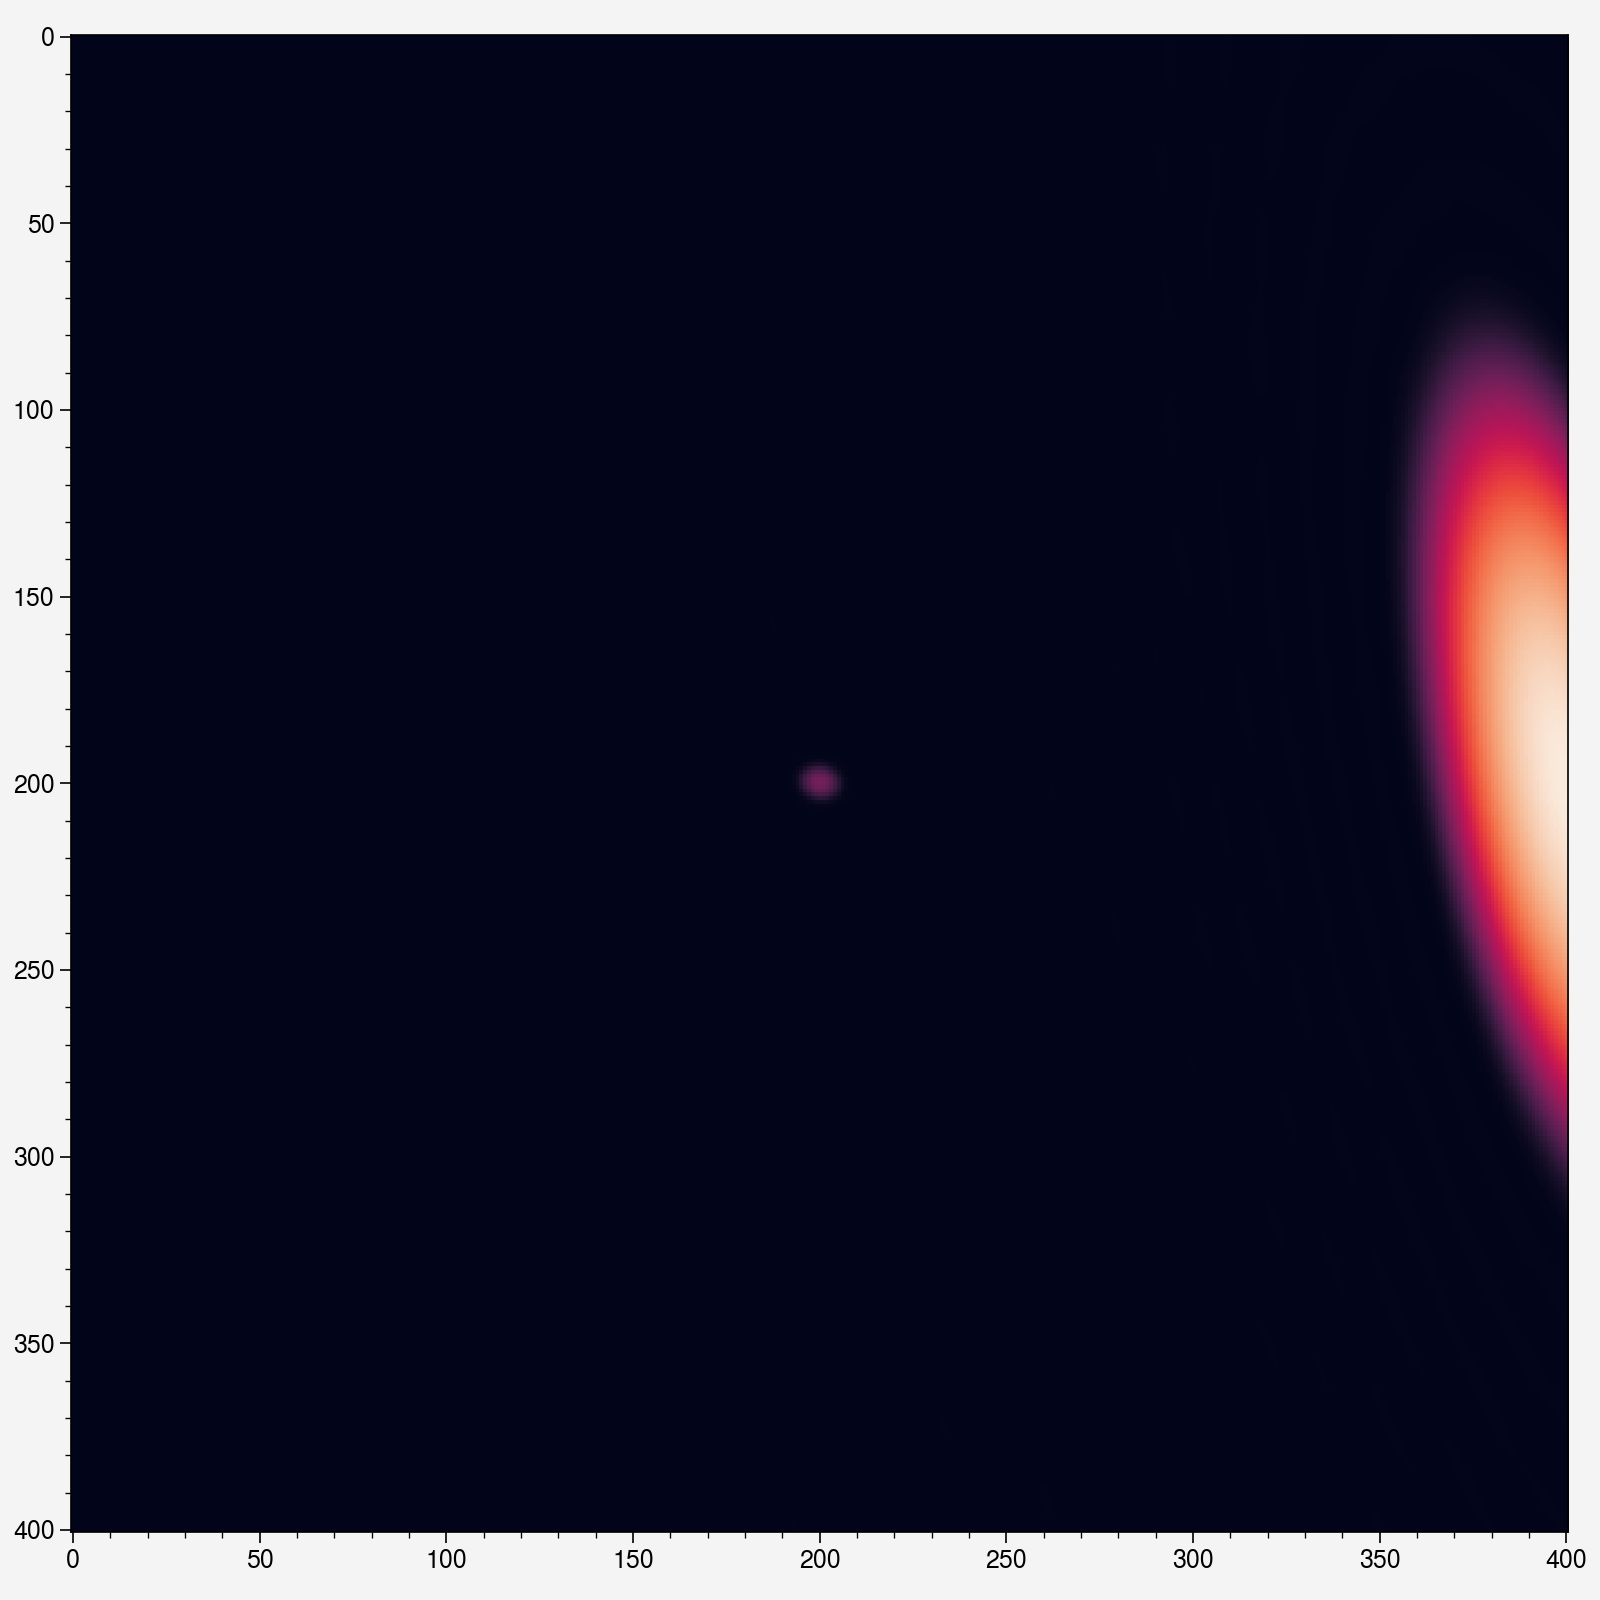

In [53]:
fig, axs = pplt.subplots(figsize=(8, 8))

axs[0].imshow(np.arcsinh(im), cmap="rocket")
axs[0].grid(False)

In [15]:
cen*0.8 * pixel_scale

55.0